In [245]:
import os
import copy
import time
import torch
import random
import numpy as np
import pandas as pd
import scipy.sparse
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

plt.style.use(["ggplot", "seaborn-poster"])
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Seeding everything for reproducibility

In [246]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [249]:
FOLDS      = 5
SEED       = 42
DISPLAY    = True
ROUND      = lambda x: np.round(x, 4)
STORE_DATA = False

PATH_TO_TRAIN_DATA  = "data/Lyrics-Genre-Train.csv"
PATH_TO_TEST_DATA   = "data/Lyrics-Genre-Test-GroundTruth.csv"
PATH_TO_STORAGE     = "storage/" 
PATH_TO_PREDICTIONS = 'predictions/'

seed_everything(seed = SEED)

# Loading Data
- For this project we are not allowed to use other features besides the lyrics, so we will remove them

In [248]:
train_data = pd.read_csv(PATH_TO_TRAIN_DATA) 
test_data  = pd.read_csv(PATH_TO_TEST_DATA)

train_data.drop(["Song", "Song year", "Artist"], axis = 1, inplace = True)
test_data.drop(["Song", "Song year", "Artist"], axis = 1, inplace = True)

# Data Visualization and Label Distribution

,Genre,Lyrics,Track_id
0,Metal,"I am a night in to the darkness, only soul los...",18096
1,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760


(18513, 3)

,Genre,Lyrics,Track_id
0,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,Indie,Take your cold hands and put them on my face\n...,21621
2,Metal,Are you ready it's time for war\nWe'll break d...,3301


(7935, 3)

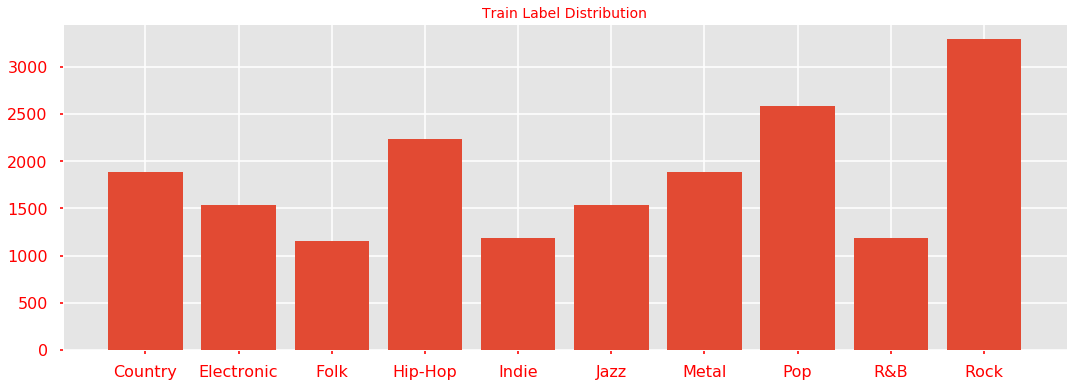

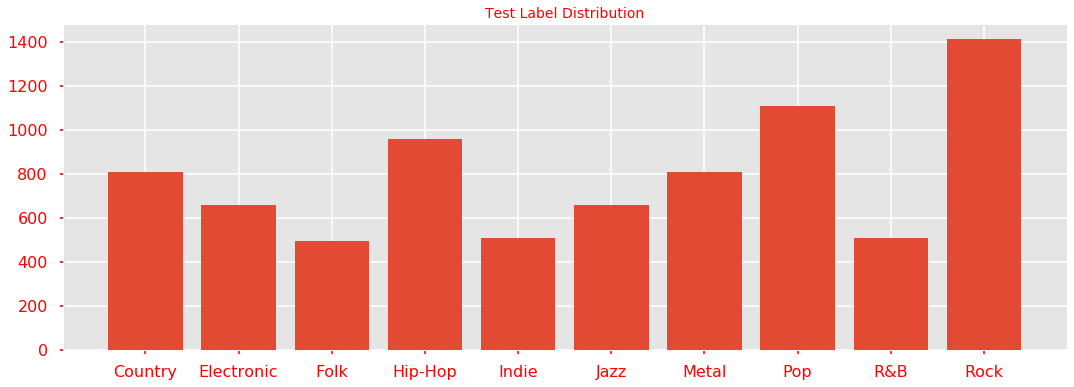

In [250]:
if DISPLAY:
    display(train_data.head(n = 3))
    display(train_data.shape)

    display(test_data.head(n = 3))
    display(test_data.shape)

    plt.figure(figsize = (18, 6))
    plt.title("Train Label Distribution", size = 14, color = 'red')
    plt.bar(*np.unique(train_data['Genre'], return_counts = True))
    plt.tick_params(axis = 'both', colors = 'red')
    plt.show()

    plt.figure(figsize = (18, 6))
    plt.title("Test Label Distribution", size = 14, color = 'red')
    plt.bar(*np.unique(test_data['Genre'], return_counts = True))
    plt.tick_params(axis = 'both', colors = 'red')
    plt.show()

# Encoding Target Variable

In [251]:
encoder = OrdinalEncoder()
encoder.fit(train_data['Genre'].values.reshape(-1, 1))
train_data['Genre'] = encoder.transform(train_data['Genre'].values.reshape(-1, 1)).astype(np.uint8)
test_data['Genre']  = encoder.transform(test_data['Genre'].values.reshape(-1, 1)).astype(np.uint8)

# Generating the folds from the beginning to ensure no data leakage 

In [273]:
skf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_data, train_data['Genre'].values)):
    train_data.loc[valid_idx, 'Fold'] = fold

train_data['Fold'] = train_data['Fold'].astype(int)    

# The main idea of this project
## Combined Model based on statistic structure, semantic structure and lyrics similarity encoding
- To obtain a broad perspective about this problem we need to look at it from various stand-points
### 1. Statistic Structure: 
Extracting statistical features based on Term Frequency - Inverse Documnet Frequency at word and character level for different n-grams
### 2. Semantic Structure:
To be able able to extract and quantify various semantinc relations from the lyrics we will try to use state of the art transformer models
### 3. Lyrics Similarity
For lyrics similarity we will use a pretrained transformer model for extracting embeddings to be later used for classification

# Stage 1: Creating statistical features with TF-IDF and storing them
- To be sure that we don't waste time recreating steps we will store the created features

### For retaining as much style our experiments during this project will be done on raw data
- The reason for that is because even basic cleaning steps as e.g. stopwords removal can affect the predictability of the genre based on lyrics
- To be researched proper cleaning techniques for text cleaning and preprocessing in future experiments

In [253]:
if STORE_DATA:
    NGRAM_RANGES = [(1, 1), (1, 2), (1, 3), (1, 5), (1, 7)]
    ANALYZERS    = ["word", "char", "char_wb"]

    for fold in range(FOLDS):
        if os.path.isdir(os.path.join(PATH_TO_STORAGE, f'fold-{fold}')) == False: 
            os.makedirs(os.path.join(PATH_TO_STORAGE, f'fold-{fold}'))

        X_train_fold = train_data[train_data["Fold"] != fold]
        X_valid_fold = train_data[train_data["Fold"] == fold]

        train_features = X_train_fold["Lyrics"]
        valid_features = X_valid_fold["Lyrics"]
        test_features  = test_data["Lyrics"]
        
        for n_grams in NGRAM_RANGES:
            for analyzer in ANALYZERS:
                tfidf = TfidfVectorizer(ngram_range = n_grams, analyzer = analyzer)
                tfidf.fit(train_features)

                X_train_features = tfidf.transform(train_features)
                X_valid_features = tfidf.transform(valid_features)
                X_test_features  = tfidf.transform(test_features)
                
                scipy.sparse.save_npz(
                    os.path.join(PATH_TO_STORAGE, f'fold-{fold}', f'train_features_ngrams_{n_grams}_analyzer_{analyzer}.npz'), 
                    X_train_features
                )

                scipy.sparse.save_npz(
                    os.path.join(PATH_TO_STORAGE, f'fold-{fold}', f'valid_features_ngrams_{n_grams}_analyzer_{analyzer}.npz'), 
                    X_valid_features
                )
                
                scipy.sparse.save_npz(
                    os.path.join(PATH_TO_STORAGE, f'fold-{fold}', f'test_features_ngrams_{n_grams}_analyzer_{analyzer}.npz'), 
                    X_test_features
                )


# Selecting the best models with regards of context
- To be able to choose the best preprocessing context that increases the predictability of the genre based on lyrics we will let our models to decide which of those is most suitable for our problem
- Based on this approach we will also increase the variance in the ensamble, some models will see the problem from the word perspective, other from character perspective
- This should lead to less correlated predictions and a higher accuracy

### At this stage, because of time constraints, we will experiment only on the first fold
### Why this is not a problem?
- Our dataset is stratified based on genre, so we should expect that our experimets to be similar with those on the other folds and our cross-validation metric should not differ by much from the initial results
- To be researched for better stratification methods

In [ ]:
NGRAM_RANGES = [(1, 1), (1, 2), (1, 3), (1, 5), (1, 7)]
ANALYZERS    = ["word", "char_wb"]

FOLD   = 0
MODELS = [
    {
        "id": "LGBM-Classifier-1",
        "model": LGBMClassifier, 
        "params": {"n_estimators": 30, "random_state": SEED, "n_jobs": - 1},
    },
    
    {
        "id": "LGBM-Classifier-2",
        "model": LGBMClassifier, 
        "params": {"n_estimators": 50, "random_state": SEED, "n_jobs": - 1},
    },
    
    {
        "id": "LGBM-Classifier-3",
        "model": LGBMClassifier, 
        "params": {"n_estimators": 100, "random_state": SEED, "n_jobs": - 1},
    },
    
    {
        "id": "SVC-1",
        "model": SVC, 
        "params": {"C" : 0.1, "random_state": SEED, "cache_size": 5000},
    },
    
    {
        "id": "SVC-2",
        "model": SVC, 
        "params": {"C" : 1, "random_state": SEED, "cache_size": 5000},
    },
    
    {
        "id": "SVC-3",
        "model": SVC, 
        "params": {"C" : 10, "random_state": SEED, "cache_size": 5000},
    },
    
    {
        "id": "RandomForest-Classifier-1",
        "model": RandomForestClassifier, 
        "params": {"n_estimators": 30, "random_state": SEED, "n_jobs": - 1},
    },
    
    {
        "id": "RandomForest-Classifier-2",
        "model": RandomForestClassifier, 
        "params": {"n_estimators": 50, "random_state": SEED, "n_jobs": - 1},
    },
    
    {
        "id": "RandomForest-Classifier-3",
        "model": RandomForestClassifier, 
        "params": {"n_estimators": 100, "random_state": SEED, "n_jobs": - 1},
    },
    
    {
        "id": "LogisticRegression-1",
        "model": LogisticRegression, 
        "params": {"C" : 0.1, "random_state": SEED, "n_jobs": 4},
    },
    
    {
        "id": "LogisticRegression-2",
        "model": LogisticRegression, 
        "params": {"C" : 1, "random_state": SEED, "n_jobs": -1},
    },
    
    {
        "id": "LogisticRegression-3",
        "model": LogisticRegression, 
        "params": {"C" : 10, "random_state": SEED, "n_jobs": -1},
    },
]
    
X_train_fold = train_data[train_data["Fold"] != FOLD]
X_valid_fold = train_data[train_data["Fold"] == FOLD]

y_train = X_train_fold["Genre"]
y_valid = X_valid_fold["Genre"]
y_test  = test_data["Genre"]

valid_predictions = pd.DataFrame()
valid_predictions["Label"] = y_valid

test_predictions = pd.DataFrame()
test_predictions["Label"] = y_test

tic = time.time()
for config in MODELS:
    for n_grams in NGRAM_RANGES:
        for analyzer in ANALYZERS:
            key = f"[{config['id']}][{analyzer}][{n_grams}]"
            X_train_features = scipy.sparse.load_npz(os.path.join(PATH_TO_STORAGE, f'fold-{FOLD}', f'train_features_ngrams_{n_grams}_analyzer_{analyzer}.npz'))
            X_valid_features = scipy.sparse.load_npz(os.path.join(PATH_TO_STORAGE, f'fold-{FOLD}', f'valid_features_ngrams_{n_grams}_analyzer_{analyzer}.npz'))
            X_test_features  = scipy.sparse.load_npz(os.path.join(PATH_TO_STORAGE, f'fold-{FOLD}', f'test_features_ngrams_{n_grams}_analyzer_{analyzer}.npz'))
            
            model = config["model"](**config["params"])
            model.fit(X_train_features, y_train)

            y_predict_valid  = model.predict(X_valid_features)
            y_predict_test   = model.predict(X_test_features)
            
            valid_predictions[key] = y_predict_valid 
            test_predictions[key]  = y_predict_test
            
            print(f"{key} Baseline Accuracy: {ROUND(accuracy_score(y_valid, y_predict_valid))}")
    
    valid_predictions.to_csv(os.path.join(PATH_TO_PREDICTIONS, "valid_predictions_stage_0.csv"), index = False)
    test_predictions.to_csv(os.path.join(PATH_TO_PREDICTIONS, "test_predictions_stage_0.csv"), index = False)

toc = time.time()
print(f"Training Stage 0 Time: {(ROUND(toc - tic))}'s")
if os.path.isdir(PATH_TO_PREDICTIONS) == False: os.makedirs(PATH_TO_PREDICTIONS)

valid_predictions.to_csv(os.path.join(PATH_TO_PREDICTIONS, "valid_predictions_stage_0.csv"), index = False)
test_predictions.to_csv(os.path.join(PATH_TO_PREDICTIONS, "test_predictions_stage_0.csv"), index = False)

# From the previous training stage, we obtained the following results

In [254]:
valid_predictions = pd.read_csv(os.path.join(PATH_TO_PREDICTIONS, "valid_predictions_stage_0.csv"))
test_predictions  = pd.read_csv(os.path.join(PATH_TO_PREDICTIONS, "test_predictions_stage_0.csv"))

In [255]:
models = []
for column in valid_predictions.columns.tolist():
    if column == 'Label': continue
    models.append((column, ROUND(accuracy_score(valid_predictions['Label'], valid_predictions[column]))))
    
models = sorted(models, key = lambda accuracy: accuracy[1], reverse = True)
print("Best 10 Models")
display(models[: 10])

Best 10 Models


[('[LGBM-Classifier-3][char_wb][(1, 5)]', 0.4351),
 ('[LGBM-Classifier-3][word][(1, 1)]', 0.4286),
 ('[LogisticRegression-3][word][(1, 2)]', 0.4278),
 ('[LGBM-Classifier-3][char_wb][(1, 7)]', 0.427),
 ('[LGBM-Classifier-3][char_wb][(1, 3)]', 0.4261),
 ('[LGBM-Classifier-3][word][(1, 3)]', 0.424),
 ('[LGBM-Classifier-3][word][(1, 5)]', 0.424),
 ('[SVC-3][word][(1, 1)]', 0.4213),
 ('[LGBM-Classifier-2][char_wb][(1, 7)]', 0.4199),
 ('[LogisticRegression-3][word][(1, 3)]', 0.4188)]

### As we expected, some models prefered word prespective other character perspective 

# Now we need the select best models from our experiments
### We will search for a threshold between 40% and 43% accuracy as a condition for the model to enter in the ensemble
- This search will be done on the validation step and applied on the test set

In [256]:
best_threshold = None 
best_accuracy  = -np.inf
for threshold in np.arange(0.40, 0.43, 0.001):
    selected_models = [key for key, accuracy in models if accuracy > threshold]
    predictions = valid_predictions[selected_models]
    predictions = predictions.values
    final_predictions = []
    for i in range(predictions.shape[0]):
        values, counts = np.unique(predictions[i], return_counts = True)
        index = np.argmax(counts)
        final_predictions.append(values[index])

    valid_predictions['Ensemble'] = final_predictions
    accuracy = accuracy_score(valid_predictions['Label'], valid_predictions['Ensemble'])
    
    if accuracy >= best_accuracy:
        best_accuracy  = accuracy
        best_threshold = threshold
        
print(f"Best Validation Accuracy: {best_accuracy} at threshold: {ROUND(best_threshold)}")

Best Validation Accuracy: 0.45989738050229545 at threshold: 0.421


### Now that we have the threshold and implicitly the models
### We need the ensure that our models predictions are as low correlated as possible for increased variance in the ensemble

In [257]:
selected_models = [key for key, accuracy in models if accuracy > best_threshold]
predictions = valid_predictions[selected_models]
display(predictions.corr())

,"[LGBM-Classifier-3][char_wb][(1, 5)]","[LGBM-Classifier-3][word][(1, 1)]","[LogisticRegression-3][word][(1, 2)]","[LGBM-Classifier-3][char_wb][(1, 7)]","[LGBM-Classifier-3][char_wb][(1, 3)]","[LGBM-Classifier-3][word][(1, 3)]","[LGBM-Classifier-3][word][(1, 5)]","[SVC-3][word][(1, 1)]"
"[LGBM-Classifier-3][char_wb][(1, 5)]",1.000000,0.495941,0.422069,0.703573,0.656552,0.484277,0.451558,0.422062
"[LGBM-Classifier-3][word][(1, 1)]",0.495941,1.000000,0.459893,0.498205,0.461701,0.616393,0.564790,0.481691
"[LogisticRegression-3][word][(1, 2)]",0.422069,0.459893,1.000000,0.420390,0.421915,0.475927,0.475776,0.650679
"[LGBM-Classifier-3][char_wb][(1, 7)]",0.703573,0.498205,0.420390,1.000000,0.656727,0.458192,0.455082,0.421316
"[LGBM-Classifier-3][char_wb][(1, 3)]",0.656552,0.461701,0.421915,0.656727,1.000000,0.436391,0.434041,0.420420
"[LGBM-Classifier-3][word][(1, 3)]",0.484277,0.616393,0.475927,0.458192,0.436391,1.000000,0.694717,0.454785
"[LGBM-Classifier-3][word][(1, 5)]",0.451558,0.564790,0.475776,0.455082,0.434041,0.694717,1.000000,0.437203
"[SVC-3][word][(1, 1)]",0.422062,0.481691,0.650679,0.421316,0.420420,0.454785,0.437203,1.000000


### As we can see, there are no strong correlated predictions so we can continue without excluding any model

# Validation and Test Accuracy based on current progress

In [258]:
predictions = predictions.values
final_predictions = []
for i in range(predictions.shape[0]):
    values, counts = np.unique(predictions[i], return_counts = True)
    index = np.argmax(counts)
    final_predictions.append(values[index])

valid_predictions['Ensemble'] = final_predictions
print("Current Validation Accuracy: {}".format(accuracy_score(valid_predictions['Label'], valid_predictions['Ensemble'])))

Current Validation Accuracy: 0.45989738050229545


In [259]:
predictions = test_predictions[selected_models].values

final_predictions = []
for i in range(predictions.shape[0]):
    values, counts = np.unique(predictions[i], return_counts = True)
    index = np.argmax(counts)
    final_predictions.append(values[index])

test_predictions['Ensemble'] = final_predictions
print("Current Test Accuracy: {}".format(accuracy_score(test_predictions['Label'], test_predictions['Ensemble'])))

Current Test Accuracy: 0.45267800882167614


# Pretty decent results on validation and test set
### Without any hyper tuning of the parameters
### Our best model obtains 43.5% accuracy on the validation set and our voting system obtains 46% accuracy
### And also test and validation results are similar

# Selected Models

In [260]:
display(selected_models)

['[LGBM-Classifier-3][char_wb][(1, 5)]',
 '[LGBM-Classifier-3][word][(1, 1)]',
 '[LogisticRegression-3][word][(1, 2)]',
 '[LGBM-Classifier-3][char_wb][(1, 7)]',
 '[LGBM-Classifier-3][char_wb][(1, 3)]',
 '[LGBM-Classifier-3][word][(1, 3)]',
 '[LGBM-Classifier-3][word][(1, 5)]',
 '[SVC-3][word][(1, 1)]']

# Usually this would be the hyper-parameter search stage
- For the selected models with preprocessing contexts, we should find the optimal hyper-parameters based on random search or bayesian optimization
- Because of time constraints, we will only try to tickle the main hyper-parameters

In [73]:
MODELS = [
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "char_wb","n_grams": (1, 5),
        "parameters": [
            {"n_estimators": 100, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 150, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 200, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 300, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 500, "random_state": SEED, "n_jobs": - 1},
        ]
    },
    
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "word", "n_grams": (1, 1),
        "parameters": [
            {"n_estimators": 100, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 150, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 200, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 300, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 500, "random_state": SEED, "n_jobs": - 1},
        ]
    },
    
    {
        "name": "LogisticRegression", "model": LogisticRegression, "analyzer": "word", "n_grams": (1, 2),
        "parameters": [
            {"C" : 7,  "random_state": SEED, "n_jobs": -1}, {"C" : 10, "random_state": SEED, "n_jobs": -1},
            {"C" : 12, "random_state": SEED, "n_jobs": -1}, {"C" : 15, "random_state": SEED, "n_jobs": -1},
            {"C" : 20, "random_state": SEED, "n_jobs": -1},
        ]
    },
    
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "char_wb", "n_grams": (1, 7),
        "parameters": [
            {"n_estimators": 100, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 150, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 200, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 300, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 500, "random_state": SEED, "n_jobs": - 1},
        ]
    },
    
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "char_wb", "n_grams": (1, 3),
        "parameters": [
            {"n_estimators": 100, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 150, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 200, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 300, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 500, "random_state": SEED, "n_jobs": - 1},
        ]
    },
    
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "word", "n_grams": (1, 3),
        "parameters": [
            {"n_estimators": 100, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 150, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 200, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 300, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 500, "random_state": SEED, "n_jobs": - 1},
        ]
    },
    
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "word", "n_grams": (1, 5),
        "parameters": [
            {"n_estimators": 100, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 150, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 200, "random_state": SEED, "n_jobs": - 1}, {"n_estimators": 300, "random_state": SEED, "n_jobs": - 1},
            {"n_estimators": 500, "random_state": SEED, "n_jobs": - 1},
        ]
    },
    
    {
        "name": "SVC", "model": SVC, "analyzer": "word", "n_grams": (1, 1),
        "parameters": [
            {"C" : 7,  "random_state": SEED}, {"C" : 10, "random_state": SEED},
            {"C" : 12, "random_state": SEED}, {"C" : 15, "random_state": SEED}, {"C" : 20, "random_state": SEED},
        ]
    },
]

In [ ]:
FOLD = 0
X_train_fold = train_data[train_data["Fold"] != FOLD]
X_valid_fold = train_data[train_data["Fold"] == FOLD]

y_train = X_train_fold["Genre"]
y_valid = X_valid_fold["Genre"]
y_test  = test_data["Genre"]

valid_predictions = pd.DataFrame()
valid_predictions["Label"] = y_valid

test_predictions = pd.DataFrame()
test_predictions["Label"] = y_test

tic = time.time()
for config in MODELS:
    key = f"[{config['name']}][{config['analyzer']}][{config['n_grams']}]"
    X_train_features = scipy.sparse.load_npz(os.path.join(PATH_TO_STORAGE, f'fold-{FOLD}', f'train_features_ngrams_{config["n_grams"]}_analyzer_{config["analyzer"]}.npz'))
    X_valid_features = scipy.sparse.load_npz(os.path.join(PATH_TO_STORAGE, f'fold-{FOLD}', f'valid_features_ngrams_{config["n_grams"]}_analyzer_{config["analyzer"]}.npz'))
    X_test_features  = scipy.sparse.load_npz(os.path.join(PATH_TO_STORAGE, f'fold-{FOLD}', f'test_features_ngrams_{config["n_grams"]}_analyzer_{config["analyzer"]}.npz'))

    for step, param in enumerate(config["parameters"]):
        second_key = key + f"[param-{step}]"
        model = config["model"](**param)
        model.fit(X_train_features, y_train)

        y_predict_valid  = model.predict(X_valid_features)
        y_predict_test   = model.predict(X_test_features)

        valid_predictions[second_key] = y_predict_valid 
        test_predictions[second_key]  = y_predict_test

        print(f"{key} Baseline Accuracy: {ROUND(accuracy_score(y_valid, y_predict_valid))}")
        valid_predictions.to_csv(os.path.join(PATH_TO_PREDICTIONS, "valid_predictions_stage_1.csv"), index = False)
        test_predictions.to_csv(os.path.join(PATH_TO_PREDICTIONS, "test_predictions_stage_1.csv"), index = False)

toc = time.time()
print(f"Training Stage 1 Time: {(ROUND(toc - tic))}'s")
if os.path.isdir(PATH_TO_PREDICTIONS) == False: os.makedirs(PATH_TO_PREDICTIONS)

valid_predictions.to_csv(os.path.join(PATH_TO_PREDICTIONS, "valid_predictions_stage_1.csv"), index = False)
test_predictions.to_csv(os.path.join(PATH_TO_PREDICTIONS, "test_predictions_stage_1.csv"), index = False)

### After this hyper-parameter search stage, we obtain the following results

In [261]:
valid_predictions = pd.read_csv(os.path.join(PATH_TO_PREDICTIONS, "final_valid_predictions_stage_1.csv"))
test_predictions  = pd.read_csv(os.path.join(PATH_TO_PREDICTIONS, "final_test_predictions_stage_1.csv"))

In [262]:
models = []
for column in valid_predictions.columns.tolist():
    if column == 'Label': continue
    models.append((column, ROUND(accuracy_score(valid_predictions['Label'], valid_predictions[column]))))
    
models = sorted(models, key = lambda accuracy: accuracy[1], reverse = True)
print("Best 10 Models")
display(models[: 10])

Best 10 Models


[('[LGBMClassifier][char_wb][(1, 5)][param-1]', 0.441),
 ('[LGBMClassifier][char_wb][(1, 5)][param-2]', 0.4402),
 ('[LGBMClassifier][char_wb][(1, 5)][param-4]', 0.4399),
 ('[LGBMClassifier][char_wb][(1, 7)][param-4]', 0.4383),
 ('[LGBMClassifier][char_wb][(1, 7)][param-1]', 0.4369),
 ('[LGBMClassifier][char_wb][(1, 7)][param-2]', 0.4367),
 ('[LGBMClassifier][char_wb][(1, 5)][param-3]', 0.4361),
 ('[LGBMClassifier][char_wb][(1, 7)][param-3]', 0.4356),
 ('[LGBMClassifier][char_wb][(1, 5)][param-0]', 0.4351),
 ('[LGBMClassifier][char_wb][(1, 3)][param-3]', 0.434)]

# Selecting the unique models with best hyper-parameters

In [263]:
unique_names   = []
unique_models  = []
unique_columns = []

for name, accuracy in models:
    unpacked_key = "/".join("".join(name.split("[")).split("]")[:3])
    param_id     = "".join(name.split("[")).split("]")[3]

    if unpacked_key not in unique_names:
        unique_names.append(unpacked_key)
        unique_models.append((unpacked_key + "/" + param_id, accuracy))

for unpacked_key, _ in unique_models:
    model, analyzer, n_grams, param_id = unpacked_key.split("/")
    key = f"[{model}][{analyzer}][{n_grams}][{param_id}]"
    unique_columns.append(key)
    
display(unique_columns)

['[LGBMClassifier][char_wb][(1, 5)][param-1]',
 '[LGBMClassifier][char_wb][(1, 7)][param-4]',
 '[LGBMClassifier][char_wb][(1, 3)][param-3]',
 '[LGBMClassifier][word][(1, 1)][param-1]',
 '[LGBMClassifier][word][(1, 3)][param-1]',
 '[LogisticRegression][word][(1, 2)][param-1]',
 '[LGBMClassifier][word][(1, 5)][param-2]',
 '[SVC][word][(1, 1)][param-0]']

# Validation and Test Accuracy based on current progress

In [264]:
predictions = valid_predictions[unique_columns]
predictions = predictions.values
final_predictions = []
for i in range(predictions.shape[0]):
    values, counts = np.unique(predictions[i], return_counts = True)
    index = np.argmax(counts)
    final_predictions.append(values[index])

valid_predictions['Ensemble'] = final_predictions
print("Current Validation Accuracy: {}".format(accuracy_score(valid_predictions['Label'], valid_predictions['Ensemble'])))

Current Validation Accuracy: 0.462597893599784


In [265]:
predictions = test_predictions[unique_columns].values

final_predictions = []
for i in range(predictions.shape[0]):
    values, counts = np.unique(predictions[i], return_counts = True)
    index = np.argmax(counts)
    final_predictions.append(values[index])

test_predictions['Ensemble'] = final_predictions
print("Current Test Accuracy: {}".format(accuracy_score(test_predictions['Label'], test_predictions['Ensemble'])))

Current Test Accuracy: 0.45784499054820416


### Now, with the best models and hyper-parameters we can compute the OOF (Out Of Fold) Accuracy 

In [106]:
MODELS = [
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "char_wb", "n_grams": (1, 5),
        "parameters": {"n_estimators": 150, "random_state": SEED, "n_jobs": - 1}
    },
    
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "char_wb", "n_grams": (1, 7),
        "parameters": {"n_estimators": 500, "random_state": SEED, "n_jobs": - 1}
    },
    
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "char_wb", "n_grams": (1, 3),
        "parameters": {"n_estimators": 300, "random_state": SEED, "n_jobs": - 1},
    },
        
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "word", "n_grams": (1, 1),
        "parameters": {"n_estimators": 150, "random_state": SEED, "n_jobs": - 1},
    },
    
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "char_wb", "n_grams": (1, 3),
        "parameters": {"n_estimators": 150, "random_state": SEED, "n_jobs": - 1},
    },
    
    {
        "name": "LogisticRegression", "model": LogisticRegression, "analyzer": "word", "n_grams": (1, 2),
        "parameters": {"C" : 10, "random_state": SEED, "n_jobs": -1},
    },
    
    {
        "name": "LGBMClassifier", "model": LGBMClassifier, "analyzer": "word", "n_grams": (1, 5),
        "parameters": {"n_estimators": 200, "random_state": SEED, "n_jobs": - 1}, 
    },
    
    {
        "name": "SVC", "model": SVC, "analyzer": "word", "n_grams": (1, 1),
        "parameters": {"C" : 7,  "random_state": SEED}, 
    }
]

# Cross Validation Training Results
- Each fold will predicti the test set resulting in $M\_MODELS * N\_FOLDS$ predictions 

In [107]:
tic = time.time()

test_predictions = pd.DataFrame()
oof = np.zeros((len(train_data), len(MODELS)))

for model_idx, config in enumerate(MODELS):
    key = f"[{config['name']}][{config['analyzer']}][{config['n_grams']}]"
    
    for fold in range(FOLDS):
        valid_idx  = train_data[train_data["Fold"] == fold].index
        second_key = key + f"[Fold-{fold}]"
        
        X_train_fold = train_data[train_data["Fold"] != fold]
        X_valid_fold = train_data[train_data["Fold"] == fold]
        
        y_train = X_train_fold["Genre"]
        y_valid = X_valid_fold["Genre"]
        y_test  = test_data["Genre"]

        X_train_features = scipy.sparse.load_npz(os.path.join(PATH_TO_STORAGE, f'fold-{fold}', f'train_features_ngrams_{config["n_grams"]}_analyzer_{config["analyzer"]}.npz'))
        X_valid_features = scipy.sparse.load_npz(os.path.join(PATH_TO_STORAGE, f'fold-{fold}', f'valid_features_ngrams_{config["n_grams"]}_analyzer_{config["analyzer"]}.npz'))
        X_test_features  = scipy.sparse.load_npz(os.path.join(PATH_TO_STORAGE, f'fold-{fold}', f'test_features_ngrams_{config["n_grams"]}_analyzer_{config["analyzer"]}.npz'))

        model = config["model"](**config["parameters"])
        model.fit(X_train_features, y_train)

        y_predict_valid  = model.predict(X_valid_features)
        y_predict_test   = model.predict(X_test_features)

        test_predictions[second_key] = y_predict_test
        oof[valid_idx, model_idx]    = y_predict_valid
                                                              
        print(f"{key} Fold: {fold} Baseline Accuracy: {ROUND(accuracy_score(y_valid, y_predict_valid))}")      
        
    pd.DataFrame(oof).to_csv("./predictions/oof.csv", index = False)
    test_predictions.to_csv("./predictions/test_predictions.csv", index = False)

[LGBMClassifier][char_wb][(1, 5)] Fold: 0 Baseline Accuracy: 0.441
[LGBMClassifier][char_wb][(1, 5)] Fold: 1 Baseline Accuracy: 0.4518
[LGBMClassifier][char_wb][(1, 5)] Fold: 2 Baseline Accuracy: 0.4418
[LGBMClassifier][char_wb][(1, 5)] Fold: 3 Baseline Accuracy: 0.4322
[LGBMClassifier][char_wb][(1, 5)] Fold: 4 Baseline Accuracy: 0.4317
[LGBMClassifier][char_wb][(1, 7)] Fold: 0 Baseline Accuracy: 0.4383
[LGBMClassifier][char_wb][(1, 7)] Fold: 1 Baseline Accuracy: 0.4429
[LGBMClassifier][char_wb][(1, 7)] Fold: 2 Baseline Accuracy: 0.4423
[LGBMClassifier][char_wb][(1, 7)] Fold: 3 Baseline Accuracy: 0.4406
[LGBMClassifier][char_wb][(1, 7)] Fold: 4 Baseline Accuracy: 0.4352
[LGBMClassifier][char_wb][(1, 3)] Fold: 0 Baseline Accuracy: 0.434
[LGBMClassifier][char_wb][(1, 3)] Fold: 1 Baseline Accuracy: 0.434
[LGBMClassifier][char_wb][(1, 3)] Fold: 2 Baseline Accuracy: 0.4321
[LGBMClassifier][char_wb][(1, 3)] Fold: 3 Baseline Accuracy: 0.4257
[LGBMClassifier][char_wb][(1, 3)] Fold: 4 Baseline 

In [267]:
out_of_fold_predictions          = pd.read_csv("./predictions/oof.csv")
out_of_fold_predictions["Fold"]  = train_data["Fold"]
out_of_fold_predictions['Label'] = train_data["Genre"]

for i in range(8): print("Model {}: OOF Accuracy: {}".format(i, accuracy_score(oof[str(i)], out_of_fold_predictions["Label"])))
    
predictions = out_of_fold_predictions[[str(i) for i in range(8)]]
predictions = predictions.values
final_predictions = []
for i in range(predictions.shape[0]):
    values, counts = np.unique(predictions[i], return_counts = True)
    index = np.argmax(counts)
    final_predictions.append(values[index])

out_of_fold_predictions['Ensemble'] = final_predictions
print("OOF Ensemble Accuracy: {}".format(accuracy_score(out_of_fold_predictions['Label'], out_of_fold_predictions['Ensemble'])))

Model 0: OOF Accuracy: 0.43969102792632203
Model 1: OOF Accuracy: 0.4398530762167126
Model 2: OOF Accuracy: 0.4301301787932804
Model 3: OOF Accuracy: 0.42440447253281477
Model 4: OOF Accuracy: 0.43045427537406145
Model 5: OOF Accuracy: 0.41992113649867663
Model 6: OOF Accuracy: 0.41959703991789554
Model 7: OOF Accuracy: 0.41446551072219523
OOF Ensemble Accuracy: 0.45724625938529684


# Stacking Methods instead of Voting System for combining models
- Unfortunately, stacking needs more hyper-parameter tuning so in our case did not improve the results

In [269]:
from xgboost import XGBClassifier

stacking = np.zeros((len(train_data),))
for fold in range(FOLDS):
    valid_idx = out_of_fold_predictions[out_of_fold_predictions["Fold"] == fold].index
    
    X_train_fold = out_of_fold_predictions[out_of_fold_predictions["Fold"] != fold]
    X_valid_fold = out_of_fold_predictions[out_of_fold_predictions["Fold"] == fold]

    y_train = X_train_fold["Label"]
    y_valid = X_valid_fold["Label"]
    
    X_train = X_train_fold[[str(i) for i in range(8)]]
    X_valid = X_valid_fold[[str(i) for i in range(8)]]
    
    model = XGBClassifier(random_state = SEED, n_jobs = -1)
    model.fit(X_train, y_train)
    
    y_predict_valid  = model.predict(X_valid)
    stacking[valid_idx] = y_predict_valid
    
    print(f"Fold: {fold} Baseline Accuracy: {ROUND(accuracy_score(y_valid, y_predict_valid))}")   
    
print("Stacking Predictions Accuracy: {}".format(accuracy_score(out_of_fold_predictions["Label"], stacking)))

Fold: 0 Baseline Accuracy: 0.4618
Fold: 1 Baseline Accuracy: 0.454
Fold: 2 Baseline Accuracy: 0.4677
Fold: 3 Baseline Accuracy: 0.4449
Fold: 4 Baseline Accuracy: 0.4495
Stacking Predictions Accuracy: 0.4555717603845946


In [270]:
oof_test_predictions = pd.read_csv("./predictions/test_predictions.csv")
oof_models = oof_test_predictions.columns.tolist()
oof_test_predictions["Label"] = test_data['Genre']

predictions = oof_test_predictions[oof_models]
predictions = predictions.values
final_predictions = []
for i in range(predictions.shape[0]):
    values, counts = np.unique(predictions[i], return_counts = True)
    index = np.argmax(counts)
    final_predictions.append(values[index])

oof_test_predictions['Ensemble'] = final_predictions
print("[Statistic Stage] Final Test Accuracy: {}".format(accuracy_score(oof_test_predictions['Label'], oof_test_predictions['Ensemble'])))

[Statistic Stage] Final Test Accuracy: 0.465658475110271


# Stage 2: Training Transformers (RoBERTa, XLNet)
- For training those models we used a 2080Ti with 11Gb using SimpleTransformers Library
- Code for the script attached in the next cell

In [221]:
if False:
    import os
    import torch
    import random
    import numpy as np
    import pandas as pd

    from sklearn.preprocessing import OrdinalEncoder

    from simpletransformers.classification import ClassificationModel
    from sklearn.metrics import accuracy_score

    import warnings
    warnings.filterwarnings("ignore")

    def seed_everything(seed = 42):
        random.seed(seed)
        np.random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    SEED = 42
    seed_everything(seed = SEED)

    train_data = pd.read_csv("data/Lyrics-Genre-Train.csv") 
    test_data  = pd.read_csv("data/Lyrics-Genre-Test-GroundTruth.csv")

    train_data.drop(["Song", "Song year", "Artist", "Track_id"], axis = 1, inplace = True)
    test_data.drop(["Song", "Song year", "Artist", "Track_id"],  axis = 1, inplace = True)

    encoder = OrdinalEncoder()
    encoder.fit(train_data['Genre'].values.reshape(-1, 1))
    train_data['Genre'] = encoder.transform(train_data['Genre'].values.reshape(-1, 1)).astype(np.uint8)
    test_data['Genre']  = encoder.transform(test_data['Genre'].values.reshape(-1, 1)).astype(np.uint8)

    train_data = train_data.rename(columns = {"Lyrics": "text", "Genre": "label"})
    test_data  = test_data.rename(columns = {"Lyrics": "text", "Genre": "label"})

    train_data          = train_data[['text', 'label']]
    train_data['text']  = train_data['text'].astype(str)
    train_data['label'] = train_data['label'].astype(int)

    test_data          = test_data[['text', 'label']]
    test_data['text']  = test_data['text'].astype(str)
    test_data['label'] = test_data['label'].astype(int)

    args = {
        "output_dir": "outputs/",
        "cache_dir": "cache_dir/",

        "fp16": True,
        "fp16_opt_level": "O1",
        "max_seq_length": 128,
        "train_batch_size": 48,
        "gradient_accumulation_steps": 1,
        "eval_batch_size": 48,
        "num_train_epochs": 10,
        "weight_decay": 0,
        "learning_rate": 7e-6,

        "adam_epsilon": 1e-8,
        "warmup_ratio": 0.06,
        "warmup_steps": 0,
        "max_grad_norm": 1.0,

        "logging_steps": 50,
        "save_steps": 2000,

        "overwrite_output_dir": True,
        "reprocess_input_data": True,
        "evaluate_during_training": True,
        "evaluate_during_training_silent": False,

        "n_gpu": 1,

        "do_lower_case": False,
        "early_stopping_consider_epochs": True,
        "early_stopping_metric": "accuracy",
        "early_stopping_metric_minimize": False,
        "early_stopping_patience": 1,
        "use_early_stopping": True,
    }

    model_name = 'roberta-base'
    model = ClassificationModel('roberta', model_name, num_labels = 10, args = args)

    model.train_model(train_data, eval_df = test_data, accuracy = lambda truth, predictions: accuracy_score(
            truth, [round(p) for p in predictions]
        ))

    result, model_outputs, wrong_predictions = model.eval_model(test_data, acc = accuracy_score)

    #print(torch.tensor(model_outputs).shape)

    print(result)
    if result['acc'] > 0.45:
        preds = pd.DataFrame()
        preds[model_name] = torch.argmax(torch.nn.functional.softmax(torch.tensor(model_outputs), dim = 1), dim = 1)
        preds.to_csv(model_name + "-" + str(np.round(result['acc'], 4)) + ".csv", index = False)

# This resulted in the following models predictions

In [271]:
transformers = pd.DataFrame()
server = [
    'server/roberta-base-0.461.csv',
    'server/roberta-base-0.4531.csv',
    'server/roberta-base-0.4534.csv',
    'server/roberta-base-0.4582.csv',
    'server/roberta-base-0.4599.csv',
    'server/xlnet-base-cased-0.4543.csv',
    'server/xlnet-base-cased-0.4573.csv',
]


for model, path in enumerate(server):
    data = pd.read_csv(path)
    if "roberta" in data.columns.tolist()[0]:
        transformers[f"model-{model}-roberta-base"] = data["roberta-base"]
    else:
        transformers[f"model-{model}-xlnet-base-cased"] = data["xlnet-base-cased"]
        
predictions = transformers[transformers.columns.tolist()]
predictions = predictions.values

final_predictions = []
for i in range(predictions.shape[0]):
    values, counts = np.unique(predictions[i], return_counts = True)
    index = np.argmax(counts)
    final_predictions.append(values[index])

transformers['Ensemble'] = final_predictions
transformers['Label']    = test_data["Genre"]

print("[Semantic Stage] Final Test Accuracy Score: {}".format(accuracy_score(transformers['Ensemble'], transformers['Label'])))

[Semantic Stage] Final Test Accuracy Score: 0.4657844990548204


# Voting System between Statistic Models and Semantic Models 

In [272]:
test_predictions = pd.read_csv("./predictions/test_predictions.csv")
models = test_predictions.columns.tolist()

for transformer_model in transformers.columns.tolist():
    test_predictions[transformer_model] = transformers[transformer_model]

display(test_predictions)

predictions = test_predictions[[col for col in test_predictions.columns.tolist() if col != "Label" and col != "Ensemble"]]
predictions = predictions.values

final_predictions = []
for i in range(predictions.shape[0]):
    values, counts = np.unique(predictions[i], return_counts = True)
    index = np.argmax(counts)
    final_predictions.append(values[index])

test_predictions['Ensemble'] = final_predictions
print("[Statistic, Semantic Stage] Final Test Accuracy: {}".format(accuracy_score(test_predictions['Label'], test_predictions['Ensemble'])))

,"[LGBMClassifier][char_wb][(1, 5)][Fold-0]","[LGBMClassifier][char_wb][(1, 5)][Fold-1]","[LGBMClassifier][char_wb][(1, 5)][Fold-2]","[LGBMClassifier][char_wb][(1, 5)][Fold-3]","[LGBMClassifier][char_wb][(1, 5)][Fold-4]","[LGBMClassifier][char_wb][(1, 7)][Fold-0]","[LGBMClassifier][char_wb][(1, 7)][Fold-1]","[LGBMClassifier][char_wb][(1, 7)][Fold-2]","[LGBMClassifier][char_wb][(1, 7)][Fold-3]","[LGBMClassifier][char_wb][(1, 7)][Fold-4]",...,"[SVC][word][(1, 1)][Fold-4]",model-0-roberta-base,model-1-roberta-base,model-2-roberta-base,model-3-roberta-base,model-4-roberta-base,model-5-xlnet-base-cased,model-6-xlnet-base-cased,Ensemble,Label
0,9,9,3,3,3,3,3,3,3,3,...,3,0,2,0,0,0,0,9,0,3
1,9,9,9,7,9,9,9,9,7,4,...,9,9,9,9,9,9,9,9,9,4
2,9,9,9,9,9,9,9,9,9,9,...,9,9,6,9,6,9,8,9,9,6
3,7,9,7,7,7,9,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
4,7,7,5,7,5,9,7,7,5,7,...,5,5,5,5,5,0,5,5,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7930,0,0,0,0,0,9,0,0,9,7,...,0,9,9,7,9,9,7,7,9,9
7931,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
7932,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
7933,9,4,4,9,9,9,4,9,4,9,...,9,9,9,9,9,9,9,9,9,9


[Statistic, Semantic Stage] Final Test Accuracy: 0.4763705103969754


##  Statistic features at word and character level with transformers obtained 47.6%

- Combining models trained on statistic features at word and character level for different ngrams with transformers obtained the highest accuracy for this project 
- Unfortunately, using embeddings for lyrics similarity did not improve the results

### In the following section I will add generating embeddings, training and prediction stage for lyrics similarity

# Generating Embeddings for Lyrics Similarity

In [239]:
if False:
    import os
    import random
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    from tqdm import tqdm
    from IPython.display import display

    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import OrdinalEncoder

    from sentence_transformers import SentenceTransformer, util

    import warnings
    warnings.filterwarnings("ignore")

    SEED = 42

    def seed_everything(seed = 42):
        random.seed(seed)
        np.random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)

    seed_everything(seed = SEED)

    train_data = pd.read_csv("data/Lyrics-Genre-Train.csv") 
    test_data  = pd.read_csv("data/Lyrics-Genre-Test-GroundTruth.csv")

    train_data.drop(["Song", "Song year", "Artist"], axis = 1, inplace = True)
    test_data.drop(["Song", "Song year", "Artist"], axis = 1, inplace = True)

    encoder = OrdinalEncoder()
    encoder.fit(train_data['Genre'].values.reshape(-1, 1))
    train_data['Genre'] = encoder.transform(train_data['Genre'].values.reshape(-1, 1)).astype(np.uint8)
    test_data['Genre']  = encoder.transform(test_data['Genre'].values.reshape(-1, 1)).astype(np.uint8)

    # display(train_data.head(n = 3))
    # display(train_data.shape)

    # display(test_data.head(n = 3))
    # display(test_data.shape)

    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train_data, train_data['Genre'].values)):
        train_data.loc[valid_idx, 'Fold'] = fold

    train_data['Fold'] = train_data['Fold'].astype(int)    

    # ! pip install transformers
    # ! pip install sentence-transformers

    model = SentenceTransformer('stsb-roberta-large')

    embeddings = pd.DataFrame(columns = ["Track_id", "Fold", "Genre"] + [f"Feature_{i}" for i in range(1024)])
    for row, sample in test_data.iterrows():
        track_id = sample['Track_id']
        lyrics   = sample['Lyrics']
        label    = sample['Genre']

        embedding = model.encode(lyrics, convert_to_tensor = True).detach().cpu().numpy().tolist()
        row = [track_id, label, fold] + embedding
        embeddings.loc[len(embeddings)] = row

        # break

    embeddings.to_csv("train_embeddings.csv", index = False)
    display(embeddings)

In [243]:
train_embeddings = pd.read_csv('data/train_embeddings.csv')
test_embeddings  = pd.read_csv('data/test_embeddings.csv')

display("Train Embeddings Shape: {}".format(train_embeddings.shape))
display("Test Embeddings Shape: {}".format(test_embeddings.shape))

'Train Embeddings Shape: (18513, 1027)'

'Test Embeddings Shape: (7935, 1026)'

In [242]:
features = [f"Feature_{i}" for i in range(1024)]

for fold in range(FOLDS):
    X_train_emeddings = train_embeddings[train_embeddings['Fold'] != fold][features]
    X_valid_emeddings = train_embeddings[train_embeddings['Fold'] == fold][features]

    y_train_emeddings = train_embeddings[train_embeddings['Fold'] != fold]["Genre"]
    y_valid_emeddings = train_embeddings[train_embeddings['Fold'] == fold]["Genre"]
    
    model = LGBMClassifier(random_state = SEED, n_jobs = -1)
    model.fit(X_train_emeddings, y_train_emeddings)
    
    y_preds_embeddings = model.predict(X_valid_emeddings)
    print(f"[Similarity Embeddings] [Fold {fold}] Baseline Accuracy: {accuracy_score(y_preds_embeddings, y_valid_emeddings)}")

[Similarity Embeddings] [Fold 0] Baseline Accuracy: 0.3575479341074804
[Similarity Embeddings] [Fold 1] Baseline Accuracy: 0.34620577909802863
[Similarity Embeddings] [Fold 2] Baseline Accuracy: 0.35565757493923844
[Similarity Embeddings] [Fold 3] Baseline Accuracy: 0.33684494867639114
[Similarity Embeddings] [Fold 4] Baseline Accuracy: 0.3419773095623987


- Even if we need as much variance as possible in our voting ensemble, we can't use a model with a score as low as ~34% accuracy

# Thing that did not work
- Using pretrained text similarity embeddings for lyrics classification (check section above)
- Removing Stop Words before TF-IDF Features
- Lowercasing before TF-IDF Features
- Training Bert/DistilBERT Transformer Models

# Ideas worth trying
- Training Transformer Model embedding and using them SVC classification head
- Finding ways for text cleaning without losing information
- Extracting styling features, training models and adding them to ensabmble
- Using more intervals for ngrams with TF-IDF